In [ ]:
!pip install natsort

In [15]:
import pandas as pd
import os
import natsort 
import cv2

In [2]:
df1 = pd.read_csv('open/test.csv')
df2 = pd.read_csv("open/train.csv")
df2.head()

,img_path,text
0,./train/train_00001.png,골목미용실
1,./train/train_00002.png,한성부동산
2,./train/train_00003.png,홍라운지
3,./train/train_00004.png,모단걸응접실
4,./train/train_00005.png,씨앗양식


In [3]:
import pandas as pd
import os

file_path = 'open/train'
file_names = os.listdir(file_path)
file_names = natsort.natsorted(file_names)
file_names[:10]

[]

In [4]:
from os import unlink

same_name = []
for f in os.listdir(file_path):
    if 'train_' in f:
        same_name.append(f)
len(same_name)

0

In [15]:
# 이미지 파일 한글라벨링
i = 0
for name in file_names:
    src = os.path.join(file_path, name)
    dst = os.path.join("/Users/jiseungmin/Desktop/AIContest/traindata", df2['text'][i]+".png")
    i+=1
    os.rename(src, dst)

In [38]:
import natsort 

file_path = 'traindata'
file_names = os.listdir(file_path)
file_names = natsort.natsorted(file_names)

for i in range(0,12160):
  src= cv2.imread("/Users/jiseungmin/Desktop/AIContest/traindata/"+file_names[[i]], cv2.IMREAD_COLOR)
  if src is None:
    print('Image load failed!')
    exit(1)
  result = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
  result = cv2.resize(result,(256,256))
  cv2.imwrite('/Users/jiseungmin/Desktop/AIContest/3/'+file_names[i],result)

TypeError: list indices must be integers or slices, not list

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [31]:
# Path to the data directory
data_dir = Path("3")
img_labels = pd.read_csv("open/train.csv")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = img_labels.text.to_list()
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 4

# Desired image dimensions
img_width = 256
img_height = 256

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 2

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])


Number of images found:  9507
Number of labels found:  12159
Number of unique characters:  1105
Characters present:  [' ', '*', '0', '1', '2', '4', '5', '7', 'X', '_', 'x', 'ㅁ', 'ㅇ', 'ㅈ', 'ㅎ', '가', '각', '간', '갈', '감', '갑', '갓', '갔', '강', '같', '개', '객', '갤', '걀', '거', '걱', '건', '걷', '걸', '검', '겁', '것', '겅', '게', '겐', '겔', '겠', '겨', '격', '견', '결', '겹', '겼', '경', '곁', '계', '고', '곡', '곤', '곧', '골', '곰', '곱', '곳', '공', '과', '곽', '관', '광', '괘', '괜', '괴', '교', '구', '국', '군', '굴', '굽', '굿', '궁', '궈', '권', '귀', '귓', '규', '귝', '균', '그', '극', '근', '글', '금', '급', '긋', '긍', '기', '긴', '긷', '길', '김', '깃', '깊', '까', '깐', '깔', '깜', '깥', '깨', '꺼', '껍', '께', '꼬', '꼭', '꼰', '꼴', '꼼', '꽁', '꽂', '꽃', '꾸', '꾼', '꿀', '꿈', '꿔', '뀐', '끄', '끈', '끌', '끓', '끔', '끝', '끼', '나', '낙', '낚', '난', '날', '남', '납', '낫', '낭', '낮', '낯', '낳', '내', '낵', '낸', '냄', '냈', '냉', '냐', '냠', '냥', '너', '넌', '널', '넓', '넘', '넙', '넝', '넣', '네', '넥', '넬', '넷', '녀', '년', '념', '녕', '노', '녹', '논', '놀', '농', '높', '놓', '놔', '뇌', '뇨', '뇽', '누', '눈

In [32]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}


In [33]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

InvalidArgumentError: Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [2], [batch]: [3] [Op:IteratorGetNext]

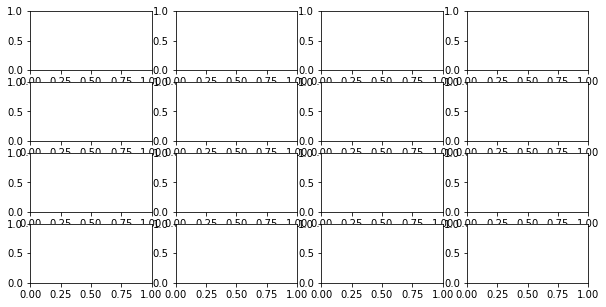

In [36]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))

batch =  train_dataset.take(1)

for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(batch_size):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8-sig")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [29]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 256, 32  320         ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 pool1 (MaxPooling2D)           (None, 128, 128, 32  0           ['Conv1[0][0]']                  
                                )                                                      

In [30]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100


2022-10-05 17:35:15.388616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


InvalidArgumentError: Graph execution error:

Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/_h/gtk6d0ts49v7qzkzs3wq6_100000gn/T/ipykernel_43102/2162554184.py", line 9, in <cell line: 9>
      history = model.fit(
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 1039, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/_h/gtk6d0ts49v7qzkzs3wq6_100000gn/T/ipykernel_43102/2162554184.py", line 9, in <cell line: 9>
      history = model.fit(
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/Users/jiseungmin/miniforge3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 1039, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [6], [batch]: [3]
	 [[{{node IteratorGetNext}}]]
	 [[ocr_model_v1/ctc_loss/mul_1/_50]]
  (1) INVALID_ARGUMENT:  Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [6], [batch]: [3]
	 [[{{node IteratorGetNext}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_36034]

In [13]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

InvalidArgumentError: Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [3], [batch]: [4] [Op:IteratorGetNext]